In [2]:
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from datetime import datetime




In [3]:
def wrangle(filepath):
    
    # Read xlsx.file
    df = pd.read_excel(filepath)
    
    df["Date"] = df["Year"].astype(str) + "-12-31" # Create a new column with string
    
    df['Date']= pd.to_datetime(df['Date']) # Change "Date" column type to 'date-time' type
    
    df = df.set_index("Date") # Set index 
    
    df.drop(columns="Year", inplace = True) # Drop 'Year' column
    
    
    
    return df
    

<AxesSubplot:xlabel='Date'>

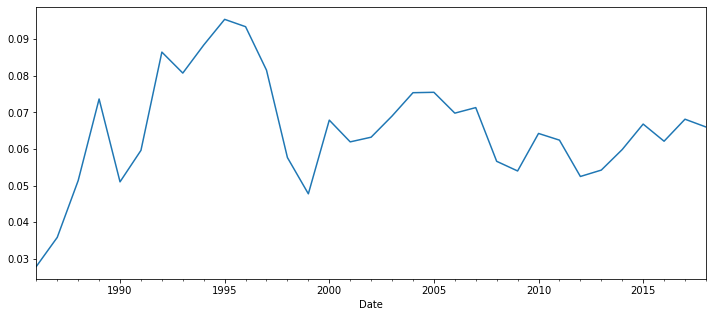

In [4]:
Data = wrangle('Documents/Real GDP annual growth rate (1986-2018).xlsx')
Data['Real GDP growth rate'].plot(figsize=(12,5))

Check for stationary

In [5]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(dataset):
    df_test = adfuller(dataset, autolag='AIC')
    print('1. ADF Statistic: %f' % df_test[0])
    print('2. p-value: %f' % df_test[1])
    print('3. Num of lags: ', df_test[2])
    print('4. Num of Obs: ', df_test[3])
    print('Critical Values:')
    for key, value in df_test[4].items():
        print('\t%s: %.3f' % (key, value))
        

In [6]:
adfuller_test(Data['Real GDP growth rate'])

1. ADF Statistic: -3.429359
2. p-value: 0.009998
3. Num of lags:  1
4. Num of Obs:  31
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


0th element = -3.429359 .It is test-statistic, more negative means likely to be stationary
p-Value = 0.009998 < 0.05 --> reject null hypothesis --> Reject non-stationary
So, this data is stationary

### Figure out order for ARIMA model

In [ ]:
# Because the dataset is stationary, so I set d = 0.
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-3
for p in range(4):
  # Loop over q values from 0-3
    for q in range(4):
      	# create and fit ARMA(p,q) model
        model = sm.tsa.statespace.SARIMAX(Data, order=(p,0,q), trend='c')
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p, q, results.aic, results.bic))

In [8]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

    p  q         AIC         BIC
5   1  1 -198.571475 -192.585445
4   1  0 -198.566087 -194.076565
1   0  1 -198.393029 -193.903506
3   0  3 -198.175739 -190.693201
8   2  0 -197.679676 -191.693646
9   2  1 -197.388154 -189.905617
2   0  2 -197.226521 -191.240491
6   1  2 -197.103688 -189.621150
7   1  3 -196.844746 -187.865700
10  2  2 -196.508947 -187.529902
13  3  1 -196.419230 -187.440185
12  3  0 -196.133950 -188.651412
14  3  2 -194.327025 -183.851472
15  3  3 -190.651407 -178.679346
11  2  3 -188.899416 -178.423863
0   0  0 -180.725858 -177.732843
    p  q         AIC         BIC
4   1  0 -198.566087 -194.076565
1   0  1 -198.393029 -193.903506
5   1  1 -198.571475 -192.585445
8   2  0 -197.679676 -191.693646
2   0  2 -197.226521 -191.240491
3   0  3 -198.175739 -190.693201
9   2  1 -197.388154 -189.905617
6   1  2 -197.103688 -189.621150
12  3  0 -196.133950 -188.651412
7   1  3 -196.844746 -187.865700
10  2  2 -196.508947 -187.529902
13  3  1 -196.419230 -187.440185
14  3  2 -

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)


<Figure size 1440x1440 with 0 Axes>

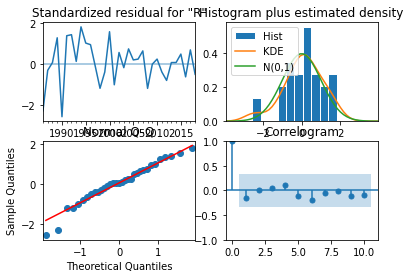

                                SARIMAX Results                                 
Dep. Variable:     Real GDP growth rate   No. Observations:                   33
Model:                 SARIMAX(3, 0, 3)   Log Likelihood                 103.326
Date:                  Sat, 02 Jul 2022   AIC                           -190.651
Time:                          11:19:00   BIC                           -178.679
Sample:                      12-31-1986   HQIC                          -186.623
                           - 12-31-2018                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0318      0.026      1.203      0.229      -0.020       0.084
ar.L1          1.4943      0.813      1.839      0.066      -0.098       3.087
ar.L2         -1.2771      1.106    

In [10]:
# Pair value (1,1) make AIC smallest, then pick (1,1) to order 
# Fit model
model = ARIMA(Data, order=(1,0,1))
#results = model.fit()

# Check diagnostics
plt.figure(figsize = (20, 20))
results.plot_diagnostics()
plt.show()
print(results.summary())

### Split Data into Training and Testing

In [11]:
print(Data.shape)
Data_train = Data.loc[:'2012']
Data_test = Data.loc['2013':]
print(Data_train.shape, Data_test.shape)

(33, 1)
(27, 1) (6, 1)


Train the model:


In [12]:
model = ARIMA(Data_train['Real GDP growth rate'], order = (1,0,1))
model = model.fit()
model.summary()

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Real GDP growth rate   No. Observations:                   27
Model:                   ARIMA(1, 0, 1)   Log Likelihood                  82.200
Date:                  Sat, 02 Jul 2022   AIC                           -156.399
Time:                          11:19:12   BIC                           -151.216
Sample:                      12-31-1986   HQIC                          -154.858
                           - 12-31-2012                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0634      0.006     11.201      0.000       0.052       0.074
ar.L1          0.4418      0.265      1.668      0.095      -0.077       0.961
ma.L1          0.5520      0.210      2.628      0.009       0.140       0.964
sigma2         0.0001   4.27e-05      2.993      0.003    4.41e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):                 1.31
Prob(Q):                              0.45   Prob(JB):                         0.52
Heteroskedasticity (H):               0.17   Skew:                            -0.52
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Make prediction on test set:

In [13]:
start = len(Data_train)
end = len(Data_train) + len(Data_test) -1
pred = model.predict(start=start, end=end, type='level')
print(pred)

2013-12-31    0.053951
2014-12-31    0.059204
2015-12-31    0.061525
2016-12-31    0.062550
2017-12-31    0.063003
2018-12-31    0.063203
Freq: A-DEC, Name: predicted_mean, dtype: float64


<AxesSubplot:xlabel='Date'>

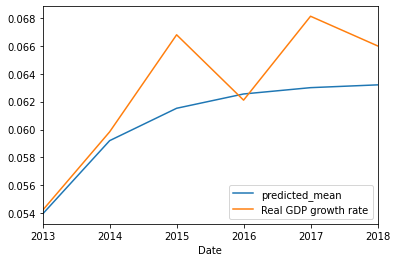

In [14]:
pred.plot(legend=True)
Data_test['Real GDP growth rate'].plot(legend=True)

In [15]:
Data_test.mean()

Real GDP growth rate    0.062846
dtype: float64

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, Data_test['Real GDP growth rate']))
print(rmse)

0.003226467471880654


In [30]:
modelX = ARIMA(Data['Real GDP growth rate'], order=(1,0,0))
modelX = modelX.fit()
Data.tail()

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)


,Real GDP growth rate
Date,
2014-12-31,0.059837
2015-12-31,0.066793
2016-12-31,0.062108
2017-12-31,0.068122
2018-12-31,0.066000


In [34]:
pred = modelX.predict(start=len(Data)-33, end=len(Data)+3, typ='level').rename('Arima Prediction')
print(pred.tail())

2018-12-31    0.066635
2019-12-31    0.065087
2020-12-31    0.064420
2021-12-31    0.063934
2022-12-31    0.063580
Freq: A-DEC, Name: Arima Prediction, dtype: float64


<AxesSubplot:>

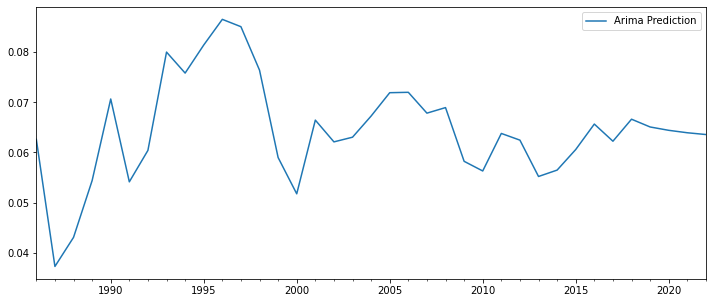

In [32]:
pred.plot(figsize=(12,5), legend=True)

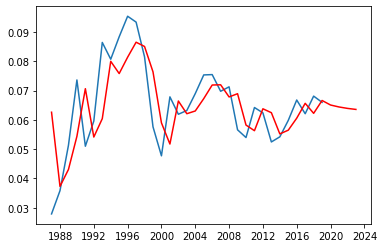

In [33]:

plt.plot(Data)
plt.plot(pred, color='r')
plt.show()

In the above plot, we can see the "red line" is one year slower than the "blue line". Then I use shift(-1) below, to get suitable
data follow year

In [35]:
pred_fix = pred.shift(-1).dropna()
pred_fix

1986-12-31    0.037288
1987-12-31    0.043082
1988-12-31    0.054400
1989-12-31    0.070664
1990-12-31    0.054151
1991-12-31    0.060424
1992-12-31    0.080012
1993-12-31    0.075830
1994-12-31    0.081420
1995-12-31    0.086537
1996-12-31    0.085075
1997-12-31    0.076409
1998-12-31    0.058991
1999-12-31    0.051763
2000-12-31    0.066453
2001-12-31    0.062117
2002-12-31    0.063050
2003-12-31    0.067268
2004-12-31    0.071918
2005-12-31    0.071997
2006-12-31    0.067844
2007-12-31    0.068949
2008-12-31    0.058242
2009-12-31    0.056317
2010-12-31    0.063797
2011-12-31    0.062463
2012-12-31    0.055219
2013-12-31    0.056492
2014-12-31    0.060590
2015-12-31    0.065665
2016-12-31    0.062248
2017-12-31    0.066635
2018-12-31    0.065087
2019-12-31    0.064420
2020-12-31    0.063934
2021-12-31    0.063580
Freq: A-DEC, Name: Arima Prediction, dtype: float64

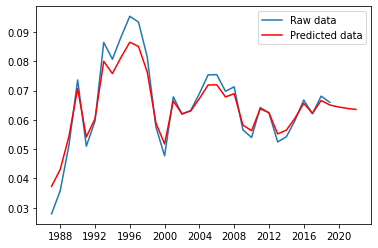

In [163]:
plt.plot(Data, label = 'Raw data')
plt.plot(pred_fix, color='r', label = 'Predicted data')
leg = plt.legend(loc='upper right')
plt.show()

### PREDICTED RESULTS
The GDP growth rate of 2019 = 6,44%
, The GDP growth rate of 2020 = 6,39%
, The GDP growth rate of 2021 = 6,35%

### ASSUMING DATA
Assuming, in 2019 have economic-crisis and the GDP growth rate of VietNam fell -0,1%.
We set the value the GDP growth rate of 31/12/2019 as -0,001

In [37]:
Data2 = wrangle('Documents/GDP annual growth rate (1986-2019).xlsx')
Data2

,Real GDP growth rate
Date,
1986-12-31,0.027893
1987-12-31,0.035835
1988-12-31,0.051350
1989-12-31,0.073645
1990-12-31,0.051009
1991-12-31,0.059608
1992-12-31,0.086460
1993-12-31,0.080727
1994-12-31,0.088390


In [38]:
adfuller_test(Data2['Real GDP growth rate'])

1. ADF Statistic: -2.157250
2. p-value: 0.222125
3. Num of lags:  0
4. Num of Obs:  33
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


p-value = 0.222125 > 0.05 => Accept null hypothesis --> Accept non-stationary So, this data is non-stationary

### Take the first difference of the data


In [88]:
Data2_diff = Data2.diff().dropna()

In [89]:
# Test adf data2_diff
adfuller_test(Data2_diff['Real GDP growth rate'])

1. ADF Statistic: -3.553859
2. p-value: 0.006707
3. Num of lags:  1
4. Num of Obs:  31
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


ADF Statistic = -3.553859 < 0 , p-value = 0.006707 < 0.05 =>> Data2_diff is stationary

### Figure out order for ARIMA model

In [ ]:
# Data2_diff is stationary => set D = 0
# Create empty list to store search results
order_aic_bic1=[]

# Loop over p values from 0-3
for p in range(4):
  # Loop over q values from 0-3
    for q in range(4):
      	# create and fit ARMA(p,q) model
        model1 = sm.tsa.statespace.SARIMAX(Data2_diff, order=(p,0,q), trend='c')
        results1 = model1.fit()
        
        # Append order and results tuple
        order_aic_bic1.append((p, q, results1.aic, results1.bic))

In [91]:
# Construct DataFrame from order_aic_bic
order_df1 = pd.DataFrame(order_aic_bic1, 
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df1.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df1.sort_values('BIC'))

    p  q         AIC         BIC
2   0  2 -175.333368 -169.347338
5   1  1 -174.632094 -168.646063
0   0  0 -174.481892 -171.488877
9   2  1 -173.605790 -166.123252
6   1  2 -173.540500 -166.057962
1   0  1 -172.626067 -168.136544
4   1  0 -172.520488 -168.030966
8   2  0 -172.371728 -166.385697
3   0  3 -172.327493 -164.844955
10  2  2 -171.544179 -162.565134
7   1  3 -171.337859 -162.358814
12  3  0 -171.310515 -163.827977
13  3  1 -170.849107 -161.870061
14  3  2 -169.804447 -159.328894
11  2  3 -168.923765 -158.448212
15  3  3 -167.134474 -155.162414
    p  q         AIC         BIC
0   0  0 -174.481892 -171.488877
2   0  2 -175.333368 -169.347338
5   1  1 -174.632094 -168.646063
1   0  1 -172.626067 -168.136544
4   1  0 -172.520488 -168.030966
8   2  0 -172.371728 -166.385697
9   2  1 -173.605790 -166.123252
6   1  2 -173.540500 -166.057962
3   0  3 -172.327493 -164.844955
12  3  0 -171.310515 -163.827977
10  2  2 -171.544179 -162.565134
7   1  3 -171.337859 -162.358814
13  3  1 -

Choose (p,q) = (0,2)

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)


<Figure size 1440x1440 with 0 Axes>

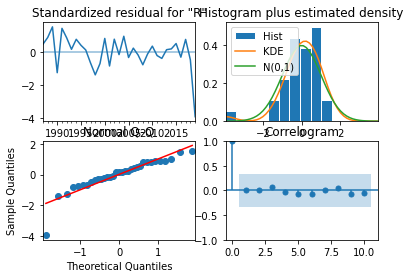

                                SARIMAX Results                                 
Dep. Variable:     Real GDP growth rate   No. Observations:                   33
Model:                 SARIMAX(3, 0, 3)   Log Likelihood                 103.326
Date:                  Sat, 02 Jul 2022   AIC                           -190.651
Time:                          11:39:27   BIC                           -178.679
Sample:                      12-31-1986   HQIC                          -186.623
                           - 12-31-2018                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0318      0.026      1.203      0.229      -0.020       0.084
ar.L1          1.4943      0.813      1.839      0.066      -0.098       3.087
ar.L2         -1.2771      1.106    

In [105]:
# Fit model
model1 = ARIMA(Data, order=(0,0,2))
# Check diagnostics
plt.figure(figsize = (20, 20))
results1.plot_diagnostics()
plt.show()
print(results.summary())

### Split Data into Training and Testing

In [106]:
#print(Data.shape)
train = Data2_diff.loc[:'2018']
test = Data2_diff.loc['2019':]
#print(train.shape, test.shape)

Train the model:

In [ ]:
model1 = ARIMA(train['Real GDP growth rate'], order = (0,0,2))
model1= model1.fit()


### Make prediction on test set:

In [137]:
start1 = len(train)
end1 = len(train) + len(test) -1
pred1 = model.predict(start=start1, end=end1, type='level')
print(pred1)

2018-12-31    0.063203
Freq: A-DEC, dtype: float64


In [ ]:
pred1.plot(legend=True)
test['Real GDP growth rate'].plot(legend=True)

In [125]:
test.mean()

Real GDP growth rate   -0.067
dtype: float64

In [138]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred1, test['Real GDP growth rate']))
print(rmse) 

0.13020262393485846


In [146]:
modelY = ARIMA(Data2_diff['Real GDP growth rate'], order=(0,0,2))
modelY = modelY.fit()
Data2_diff.tail() 

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)


,Real GDP growth rate
Date,
2015-12-31,0.006956
2016-12-31,-0.004685
2017-12-31,0.006014
2018-12-31,-0.002122
2019-12-31,-0.067000


In [147]:
pred1 = modelY.predict(start=len(Data2_diff)-1, end=len(Data2_diff)+4, typ='level').rename('Arima1 Prediction')
print(pred1)

2019-12-31   -0.009905
2020-12-31   -0.012614
2021-12-31    0.031711
2022-12-31   -0.000579
2023-12-31   -0.000579
2024-12-31   -0.000579
Freq: A-DEC, Name: Arima1 Prediction, dtype: float64


<AxesSubplot:>

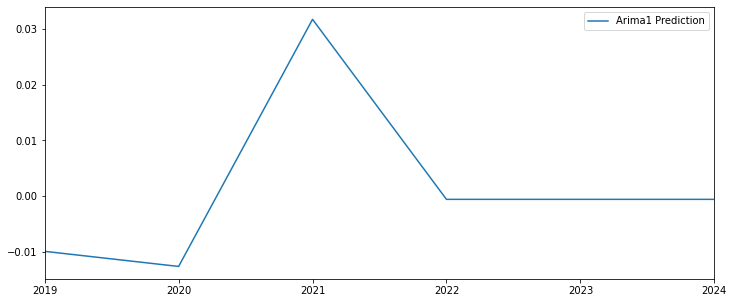

In [148]:
pred1.plot(figsize=(12,5), legend=True)

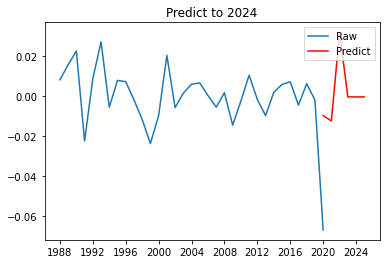

In [161]:
plt.plot(Data2_diff, label='Raw')
plt.plot(pred1, color='r', label='Predict')
plt.title('Predict to 2024')
leg = plt.legend(loc='upper right')
plt.show()

### PREDICT RESULTS:
The GDP growth rate of 2020 = -0.012614 (-1,26%), The GDP growth rate of 2021 = 0.031711(0,3%)